## Predicting presence or absence of microbial photosynthesis in hot springs using conditional inference trees (demo)

In [1]:
# read .csv database of photosynthesis observations and corresponding geochemical measurements
allsites <- read.csv("../YNP_PS.csv")

In [2]:
summary(allsites)[, 1:12] # For this demo, summarize first 12 columns of dataset. What kind of cleanup is needed?

      File                  Name          Sample          Year     
 Min.   :   1   Lobster Claw  :  11   60810  :   9   Min.   :2001  
 1st Qu.: 276   Roman Bath    :  10   60809  :   3   1st Qu.:2008  
 Median : 551   The Dryer     :  10   070711C:   2   Median :2010  
 Mean   : 551   Milk Chocolate:   8   010727L:   1   Mean   :2009  
 3rd Qu.: 826   Acid Pants    :   7   010727M:   1   3rd Qu.:2011  
 Max.   :1101   Bison Pool    :   7   010729P:   1   Max.   :2015  
                (Other)       :1048   (Other):1084                 
               Area     PS            pH             pH_cb          
 GOPA            :124    :261   Min.   : 0.797   Min.   :-999.0000  
 Sylvan          :105   M: 37   1st Qu.: 2.907   1st Qu.:   2.9890  
 Sentinel Meadow : 72   N:604   Median : 5.399   Median :   6.5170  
 Amphitheater    : 57   Y:199   Mean   : 5.746   Mean   :   0.6558  
 Sentinel Meadows: 55           3rd Qu.: 8.168   3rd Qu.:   8.4840  
 Sylvan Spring   : 51           Max.   :11

In [3]:
# data cleanup
allsites[allsites == -999] <- NA # all placeholder -999 values changed to NA
allsites[allsites == 0] <- NA # all measurements of 0 (below detection) changed to NA
allsites$Eh[is.na(allsites$O2) == TRUE] <- NA # if O2 is not available, exclude Eh (oxidation potential) results
allsites$Year <- as.factor(allsites$Year) # factor field years into levels


"Summary of pH"
summary(allsites$pH)

"Summary of Temperature, C"
summary(allsites$Temperature)

"Summary of Sulfide, ppb"
summary(allsites$HS.)

"Photosynthesis observations"
"Y = Yes, photosynthesis observed; N = No, photosynthesis not observed; M = maybe photosynthesis"
"(note that levels other than Y, N, and M appear, which will be addressed later)"
summary(allsites$PS)

[1] "Summary of pH"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.797   2.907   5.399   5.746   8.168  11.900 

[1] "Summary of Temperature, C"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.50   38.90   65.60   60.59   81.60   97.30 

[1] "Summary of Sulfide, ppb"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0017     392 

[1] "Photosynthesis observations"

[1] "Y = Yes, photosynthesis observed; N = No, photosynthesis not observed; M = maybe photosynthesis"

[1] "(note that levels other than Y, N, and M appear, which will be addressed later)"

M   N   Y 
261  37 604 199

Warning message:
"package 'ggplot2' was built under R version 3.3.3"Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 2 rows containing missing values (geom_bar)."

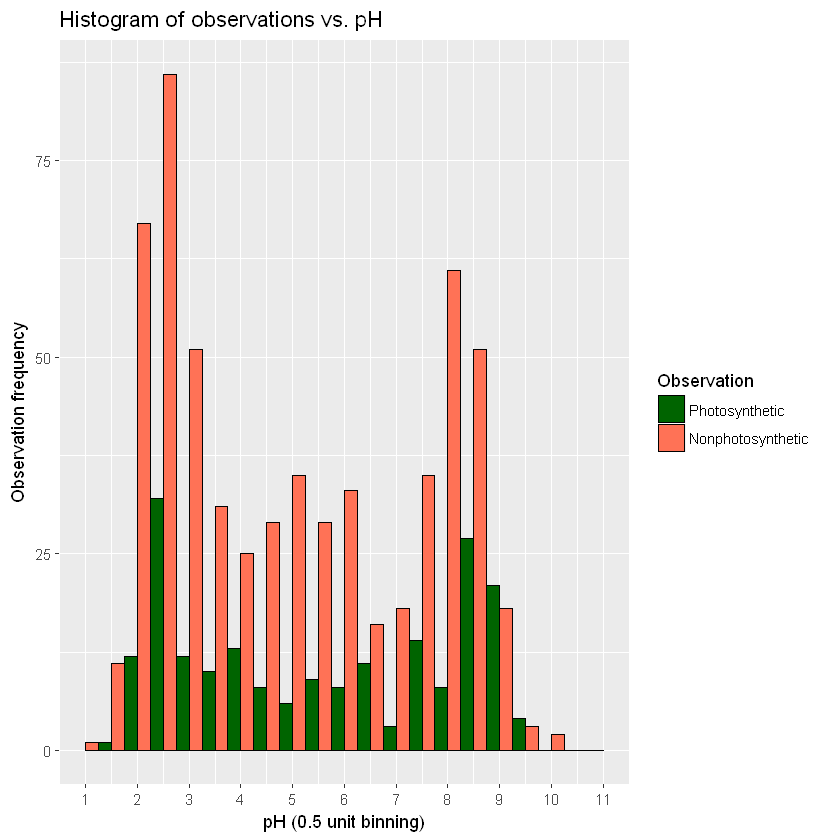

In [4]:
library(ggplot2)
df <- rbind(data.frame(fill="darkgreen", group=allsites[allsites$PS == "Y", "pH"]),
            data.frame(fill="coral1", group=allsites[allsites$PS == "N", "pH"]))

ggplot(df, aes(x=group, fill=fill)) +
  geom_histogram(binwidth=.5, colour="black", position="dodge") +
  scale_fill_identity() +
  ggtitle("Histogram of observations vs. pH") +
  ylab("Observation frequency") +
  scale_fill_manual(name="Observation", values=c("darkgreen","coral1"), labels=c("Photosynthetic","Nonphotosynthetic")) + 
  scale_x_continuous(name="pH (0.5 unit binning)", limits=c(1, 11), breaks = seq(1, 11, 1))

### Samples show a bimodal distribution of pH, with most falling between pH 1-3 (acidic) and 8-10 (alkaline). Photosynthesis is observed across the entire range of pH.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_bar)."

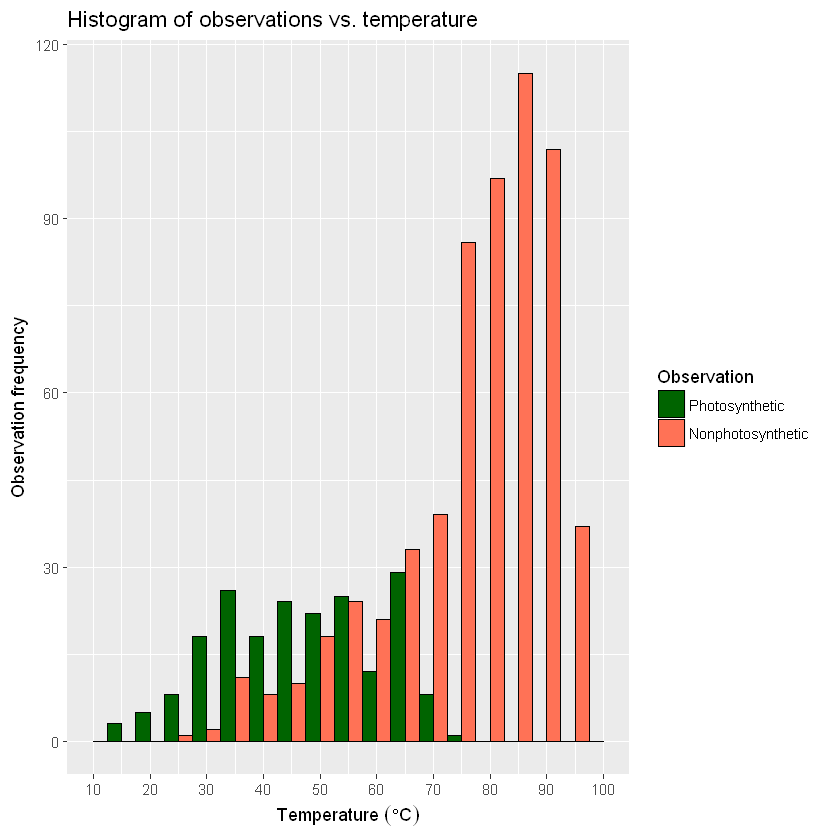

In [5]:
library(ggplot2)
df <- rbind(data.frame(fill="darkgreen", group=allsites[allsites$PS == "Y", "Temperature"]),
            data.frame(fill="coral1", group=allsites[allsites$PS == "N", "Temperature"]))

ggplot(df, aes(x=group, fill=fill)) +
  geom_histogram(binwidth=5, colour="black", position="dodge") +
  scale_fill_identity() +
  ggtitle("Histogram of observations vs. temperature") +
  ylab("Observation frequency") +
  scale_fill_manual(name="Observation", values=c("darkgreen","coral1"), labels=c("Photosynthetic","Nonphotosynthetic")) + 
  scale_x_continuous(name=expression("Temperature " ( degree*C)), limits=c(10, 100), breaks = seq(10, 100, 10))

### Photosynthesis is only observed below 75 $^{\circ}$C, but temperature can't be the only variable explaining presence/absence of photosynthesis.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
"Removed 259 rows containing non-finite values (stat_bin)."Warning message:
"Removed 2 rows containing missing values (geom_bar)."

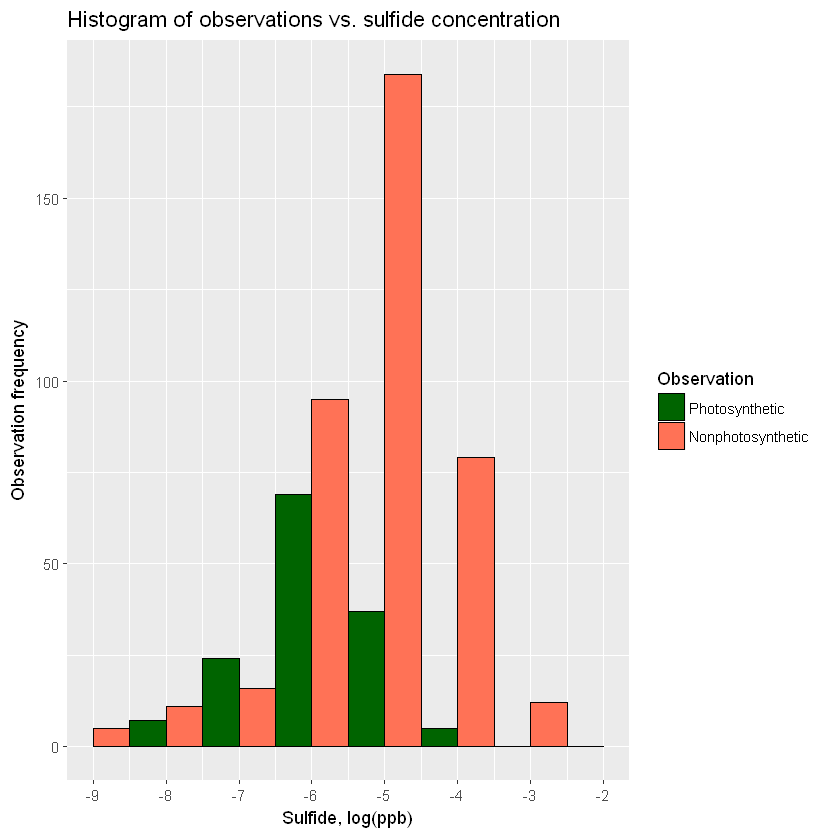

In [6]:
library(ggplot2)
df <- rbind(data.frame(fill="darkgreen", group=log10(allsites[allsites$PS == "Y", "HS."])),
            data.frame(fill="coral1", group=log10(allsites[allsites$PS == "N", "HS."])))

ggplot(df, aes(x=group, fill=fill)) +
  geom_histogram(binwidth=1, colour="black", position="dodge") +
  scale_fill_identity() +
  ggtitle("Histogram of observations vs. sulfide concentration") +
  ylab("Observation frequency") +
  scale_fill_manual(name="Observation", values=c("darkgreen","coral1"), labels=c("Photosynthetic","Nonphotosynthetic")) + 
  scale_x_continuous(name=expression("Sulfide, log(ppb)"), limits=c(-9, -2), breaks = seq(-9, -2, 1))

### Dissolved sulfide is commonly claimed to be an inhibitor of photosynthesis. Indeed, sites with higher concentrations of sulfide tend to have fewer observations of photosynthesis.

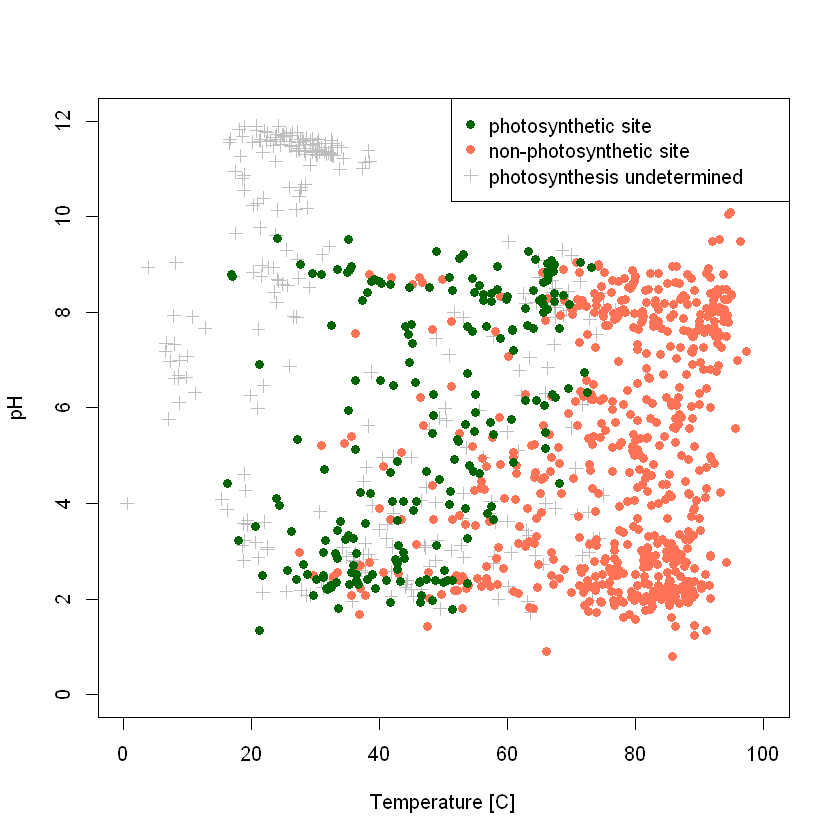

In [7]:
Ysites <- allsites[allsites$PS == "Y",]
Nsites <- allsites[allsites$PS == "N",]
Msites <- allsites[allsites$PS != "Y" & allsites$PS != "N", ] # group all other observations into "M" for "maybe"

plot(Msites$Temperature, Msites$pH, ylim = c(0, 12), xlim = c(0, 100), ylab = "pH",
     xlab = "Temperature [C]", pch = 3, col = "gray", main = "")
points(Nsites$Temperature, Nsites$pH, pch = 19, col = "coral1")
points(Ysites$Temperature, Ysites$pH, pch = 19, col = "darkgreen")
legend("topright", legend=c("photosynthetic site", "non-photosynthetic site", "photosynthesis undetermined"),
       pch = c(19, 19, 3), col = c("darkgreen", "coral1", "gray"))

### Plotting pH against temperature reveals a possible effect of both variables on the maximum allowable temperature of photosynthesis; low pH sites tend to exhibit a lower maximum temperature threshold for photosynthesis (50-60$^{\circ}$C) than high pH sites (70-75$^{\circ}$C). This trend was first described in [Cox et al. 2011](https://doi.org/10.1016/j.chemgeo.2010.11.022).

### Using machine learning to create a model to predict whether a site will be photosynthetic using conditional inference trees in R.

In [8]:
# Create our Yes/No-only training set
train <- rbind(Ysites, Nsites)

# Summarize photosynthesis observations. Notice that levels other than "Y" and "N" are still showing up for PS.
summary(train$PS)

M   N   Y 
  0   0 604 199

In [9]:
# drop unused levels:
train$PS <- droplevels(train$PS)

# Only levels Y and N are present
summary(train$PS)

N   Y 
604 199

In [10]:
n <- nrow(train)
n

[1] 803

In [11]:
ntrain <- round(n*0.8)
ntrain

[1] 642

In [12]:
set.seed(654321)
tindex <- sample(n, ntrain) # sample 80% of the data to train/create the model
tindex # training sample index

[1]  80 409 738 219 510 776 511 314 205 230 759 671 295 604 399 518 471 561
 [19] 463 534 651 204 771 522 488 642 605 321  81 532 489 578 591 505 347 720
 [37] 770 717 308 553 413 366 780 461 537 594 164 672 304 403 146 685 339  42
 [55] 649  49 664 525  41 644 676 526 330 493 616 356 790 434 372 407 733  52
 [73] 206 300 545 332 517 725 210 484 298 353 730 229  95 159 758 586 112 139
 [91] 481 438 214 607 394 765 453 736 361  18 433  44 296 800 620  45 351  14
[109]   7 789 535 395 416 608 523 661   2 278  66 689  72 788 426 480 731 495
[127]  60 786  51 363 151 487 600  35 412 476 502 196  20 148 512 551 160 792
[145] 176 572  78 569 473 669  40 154 350 630 223 632 192 233 714 271 482 193
[163]  21 621 590 177 245 802  65  88 795 501 390 546  43 269 634 410 602 191
[181] 107 718 763 415  28  84 576   9 228  77 739 338  90 352 294 185 503 692
[199] 490 400 446 571 285 279 306 653 121 784 297 123  74 441 227 764  83 687
[217] 782 324 585 421 659 124 178 762 117  64 497 103 724  16 357 358 188  54
[235]  59 592 262 365 555 319 364 626 528 598 623 475 127 243 442 631 466 743
[253] 799 541 622  32  19 182 641 256 695  50 706 584 753  79  38 509 628 670
[271]   1 444  11 774 126 556 516 138 346  15 379 325 575 702 454  87  27 157
[289] 557 180 697 727 288 667 468 322 506 341 397 593 266 303 750 354 514 700
[307] 109 320 698 345 440 452 118 803  73  12 224 402 423 327  70 647 249 701
[325] 104 570 715 662 614 301 521 253 699 261   6 688 221 232 432 673 675 240
[343] 654 246 611  25 235 302 637  36 212 336 574 558 396 108 183  46 406 331
[361] 732  58  94 726 684 315 284 754 559 722 186 149 716 624 633  24 307  96
[379] 391 376 515 683 640 459 465 744 721 381 137 588 384 116 519 436 573 316
[397] 281 617 437 171 299 496 258 323 405  29 359 367 197 533 130 378 710 181
[415] 198 707 513 767 250 768 791 340  61 280 115 680 603  75   3 387 752 618
[433] 428  17 218 756 411 755 693 524 179 105 273 293  86 369 745 462  67 166
[451] 613 435 174 239 282 639 371 202 277 417 769 100 337 207 165 691 276 451
[469] 385 499 255 458  98 470 708 507 562 380 430  62 777 275  31 652 252 741
[487] 766 102 161 548 248 627  53 386 305 796  55 682 635 711   4 251 696 712
[505] 189  57 460 625 540 209 286 129 419 520  39 797 779 477 225 606  69 686
[523] 144 772 290 195 401 431 747 485 793 554 577 794 392 508 615 200 158 679
[541] 658 587 377 737 645 292 773 335 226 599 787 486 382 389 134  13 491 150
[559] 719 723 565 155 374 257  99 270 328 751   8 657 190 247 388  30 145  85
[577] 704 310 373 778 135 355 563 414 238 660  76 472 326 678 500 344 610 260
[595] 272  68 167 131 646 531 746 234 236 309 529 597 128 216 474 560 187 705
[613] 536 122 504 343 111 713 478 169 439 456 168 494 141 567 429 333 582 492
[631] 106 263 199  97 609  89 313 690 579 133 449 595

In [13]:
xtrain <- train[tindex, ] # train the model on our sampled training data
xtest <- train[-tindex, ] # the remaining 20% will be set aside for testing our model

head(xtrain)
head(xtest)

,File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Cs.,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2
318,318,Blondie Zygo Mat,120721TZ,2012,Sylvan,Y,2.520,2.275,-11.5684,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
357,357,Fudge Factory,090725CA,2009,GOPA,N,4.408,4.479,0.1317,0.8824,...,2.41e-07,3.57e-07,1.87e-09,1.01e-10,3.75e-07,7.34e-10,5.21e-10,4.91e-10,2.77e-10,NA
831,831,MLS Outflow 1 OFF,100729I1,2010,Imperial Geyser Basin,N,8.635,8.471,-1.5689,NA,...,1.20e-06,4.88e-09,2.16e-11,5.04e-11,2.16e-06,7.34e-10,1.01e-10,7.76e-11,1.13e-10,NA
29,29,Hell's Gate,080729A,2008,Rabbit South,N,3.960,3.941,-0.2270,0.9123,...,2.64e-08,1.52e-07,1.56e-09,NA,1.14e-10,1.86e-09,2.47e-09,1.25e-09,3.23e-09,NA
490,490,Devil's Ani Hot,010729T,2001,Sylvan,N,2.300,2.192,-12.3827,1.0223,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
903,903,Spitting Croisant,100804UA,2010,Geyser Creek Field Blank,N,4.930,9.514,14.9348,NA,...,1.69e-06,2.33e-08,1.73e-09,6.72e-11,1.49e-07,2.74e-10,2.32e-09,1.47e-10,3.70e-10,NA


,File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Cs.,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2
35,35,Sex on the Beach,110708C,2011,Rabbit Creek North,Y,3.943,5.211,14.0260,0.9449,...,3.84e-07,1.09e-07,7.92e-11,2.41e-10,7.07e-10,5.38e-10,4.54e-10,4.31e-12,4.29e-10,NA
51,51,Allagash,110710B,2011,Rabbit Creek South,Y,4.670,6.199,31.0835,0.9019,...,4.44e-08,1.60e-07,1.22e-09,7.28e-11,1.52e-09,5.04e-10,5.26e-10,3.45e-11,1.05e-09,NA
115,115,Fuzzy Bacon,110718M,2011,Amphitheater,Y,4.640,7.744,4.7809,0.9144,...,1.36e-07,2.85e-07,5.83e-10,3.92e-10,1.08e-08,2.10e-10,1.11e-10,3.45e-11,1.26e-11,NA
117,117,Orange Dream Slush,110718O,2011,Amphitheater,Y,5.944,7.637,3.3387,0.8488,...,1.38e-07,2.50e-07,3.31e-10,5.60e-12,8.24e-09,5.14e-10,4.83e-11,4.31e-12,1.26e-11,NA
134,134,Mr. Toad,110720D1,2011,Rabbit Creek South,Y,4.233,5.743,23.1236,0.9447,...,1.50e-08,1.12e-07,1.66e-09,8.96e-11,5.66e-09,3.38e-10,5.89e-10,3.15e-10,5.97e-10,NA
193,193,Sherbert Bowl,120721SC,2012,Amphitheater,Y,6.950,7.378,2.8436,0.7628,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [14]:
# install.packages("partykit", repos="http://cran.us.r-project.org")
library(partykit) # package containing ctree()

Warning message:
"package 'partykit' was built under R version 3.3.3"Loading required package: grid


In [15]:
Photo_model <- ctree(formula = PS ~ pH + Temperature, data = xtrain) # create a ctree model with our training set

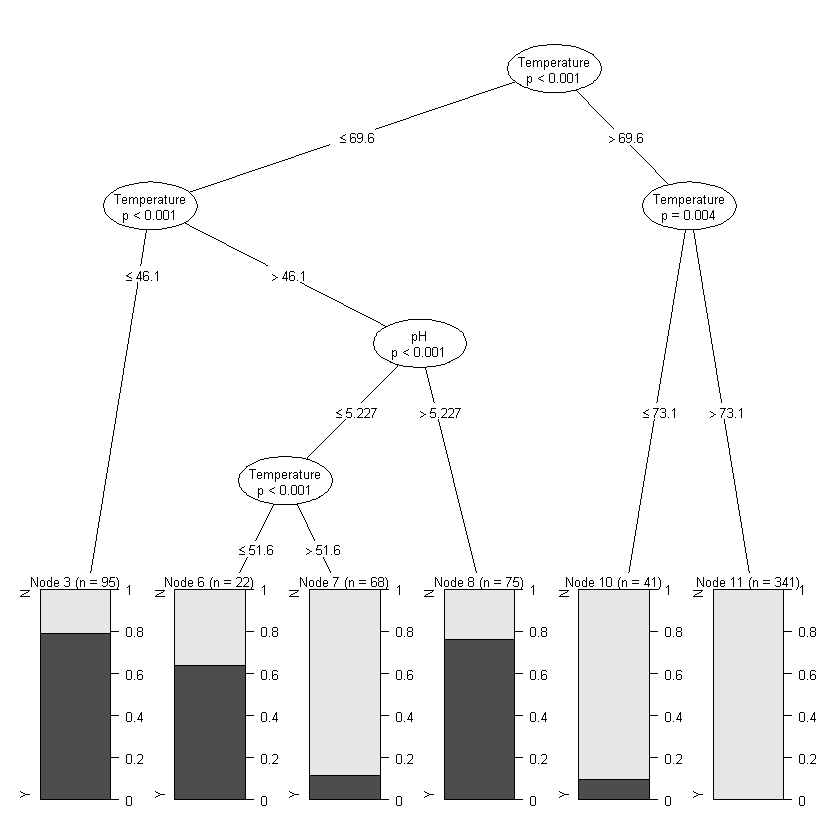

In [16]:
plot(Photo_model, gp = gpar(fontsize = 8),
  inner_panel=node_inner,
  ip_args=list(abbreviate = FALSE, id = FALSE)
  )

In [17]:
Photo_pred <- predict(object = Photo_model, newdata = xtest)
length(Photo_pred)
length(xtest$PS)
xtest$PS

[1] 161

[1] 161

[1] Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
 [38] Y Y Y Y N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
 [75] N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
[112] N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
[149] N N N N N N N N N N N N N
Levels: N Y

In [18]:
# install.packages("caret", repos="http://cran.us.r-project.org")
# install.packages("e1071", repos="http://cran.us.r-project.org")
library(caret)

Loading required package: lattice


In [19]:
# test our model on the 20% remaining data
confusionMatrix(data = Photo_pred, reference = xtest$PS)

Confusion Matrix and Statistics

          Reference
Prediction   N   Y
         N 105   4
         Y  15  37
                                          
               Accuracy : 0.882           
                 95% CI : (0.8219, 0.9274)
    No Information Rate : 0.7453          
    P-Value [Acc > NIR] : 1.435e-05       
                                          
                  Kappa : 0.7144          
 Mcnemar's Test P-Value : 0.02178         
                                          
            Sensitivity : 0.8750          
            Specificity : 0.9024          
         Pos Pred Value : 0.9633          
         Neg Pred Value : 0.7115          
             Prevalence : 0.7453          
         Detection Rate : 0.6522          
   Detection Prevalence : 0.6770          
      Balanced Accuracy : 0.8887          
                                          
       'Positive' Class : N               
                                          

### This decision tree model, trained on pH and temperature alone, predicts photosynthesis with 88% accuracy. Four "yes" sites were incorrectly categorized as nonphotosynthetic and 15 "no" sites as photosynthetic.

### Next, sulfide will be included in this model. Will this variable improve accuracy?

In [20]:
# only include data with a sulfide measurement
train_HS <- train[is.na(train$HS.) == FALSE, ]

n <- nrow(train_HS)
n

[1] 545

In [21]:
ntrain <- round(n*0.8)
ntrain

[1] 436

In [22]:
tindex <- sample(n, ntrain) # sample 80% of the data to train/create the model
tindex # training sample index

[1] 368   9 112  90 100 454 258 348 420 450  58 192 159 140 243 242  54 295
 [19] 349  81 528  32 146  48 324 427 412  78  71 123 110 142  41  63 239 445
 [37]  75 268 127  59 128  51   5  39 129 298 438 136 517 148 336 247 398 177
 [55]   1 302 485 125 229  15 117 455   4  52 432 238 175 519 457 111 402 413
 [73] 372 160  91 533 172 429 223 282  99 434 390 510 203 225 515 133  19 524
 [91] 134 244 167 484 440 191 462 509 283 369 497  20 480 237 449 371 318 393
[109]  12  76   3 385 315  31 240  23   8 323  57 306  85  67 178 274   2 260
[127] 163 494 312 257 426 277 478 121 290 186 540 253 387 147 544 216 538 417
[145] 474 513 481 334 281 251 156 388 536 105 407 456  72 188 503 161 527 228
[163] 275 332 532 226 227 512  66 541 296 262 442 252 342 190 516 152 361  16
[181] 284 149 424 362 422 486 495  87  45 120 165 249 276 219 375 206 322 144
[199] 339  36 286  30 346 379 364  28 353 130 304 259 316 473 288 399 319 269
[217]  56 520  82 370 490 436 367 360 451  79 236 279  92 446 254 415 131 437
[235] 107 241 194 325 366 201  69  11 350 347 106 355 335 204 270 245 122  53
[253] 502 463 391  62 317  10 307 416 326 341  24 459 280 314 423 539 488 505
[271] 170 378  38 224 521  95 392 327 309  70 263 272 313 138 383 507 352 338
[289] 345  93  14 357 418  65 439 145 218 102  94  80 363  64 182 248 491 333
[307] 230 222 291 109 380 184 543 215 137 199 489 479 461 394 271 209 126  47
[325] 331 523 143 256 168 158 250 537 208 430 234  37  77 506  33 508 531 300
[343] 358 409 452 469 220 108   7 468 287 116 217 466 535  60  18 472 443 458
[361] 320 293 210 231 301 534 119 124  34 493  89 183 401 321 351 278 441 381
[379] 425 504 166  43 273 477 499 132 444 232 118 414 153 180 545 311 431 526
[397] 213 428 150 359 460 310 154 386 174 382 384 155 212 464  22 196 294 501
[415] 265  35 305 406 211 500 266 261 344  50 151 297 292 389 476 173 403 498
[433] 404  97  55 377

In [23]:
xtrain <- train_HS[tindex, ] # train the model on our sampled training data
xtest <- train_HS[-tindex, ] # the remaining 20% will be set aside for testing our model

In [24]:
Photo_model <- ctree(formula = PS ~ pH + Temperature + log10(HS.), data = xtrain) # create a ctree model with our training set

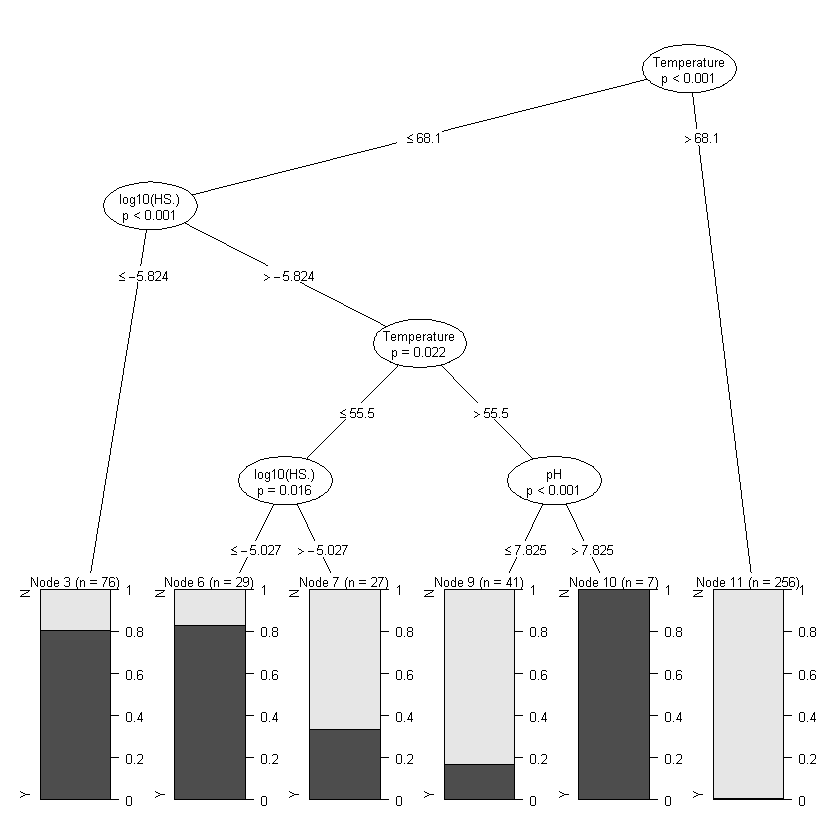

In [25]:
plot(Photo_model, gp = gpar(fontsize = 8),
  inner_panel=node_inner,
  ip_args=list(abbreviate = FALSE, id = FALSE)
  )

In [26]:
Photo_pred <- predict(object = Photo_model, newdata = xtest)
length(Photo_pred)
length(xtest$PS)
xtest$PS

[1] 109

[1] 109

[1] Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y N N N N N
 [38] N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
 [75] N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
Levels: N Y

In [27]:
# test our model on the 20% remaining data
confusionMatrix(data = Photo_pred, reference = xtest$PS)

Confusion Matrix and Statistics

          Reference
Prediction  N  Y
         N 72  6
         Y  5 26
                                          
               Accuracy : 0.8991          
                 95% CI : (0.8266, 0.9485)
    No Information Rate : 0.7064          
    P-Value [Acc > NIR] : 1.167e-06       
                                          
                  Kappa : 0.7545          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9351          
            Specificity : 0.8125          
         Pos Pred Value : 0.9231          
         Neg Pred Value : 0.8387          
             Prevalence : 0.7064          
         Detection Rate : 0.6606          
   Detection Prevalence : 0.7156          
      Balanced Accuracy : 0.8738          
                                          
       'Positive' Class : N               
                                          

### Including sulfide offers only marginal improvement of the model, though it is necessary to note that the dataset used to construct this model uses a smaller subset of data (only those with a sulfide measurement).

### End of demo